# Hybrid quantum-classical Neural Networks with PyTorch and Qiskit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

In [2]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples]
               )

# idx = np.append(idx, 
#                 np.where(X_train.targets == 2)[0][:n_samples]
#                )
# idx = np.append(idx, 
#                 np.where(X_train.targets == 3)[0][:n_samples]
#                )

print(idx)


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

[   1   21   34   37   51   56   63   68   69   75   81   88   95  108
  114  118  119  121  156  169  192  206  209  210  216  229  232  234
  246  249  260  283  293  296  303  320  326  359  399  427  429  435
  440  451  453  458  462  464  473  489  519  524  526  527  542  577
  582  596  603  612  633  639  656  662  666  667  668  669  689  702
  709  712  733  743  745  776  781  787  790  818  825  849  859  860
  869  872  889  903  927  943  949  952  957  965  979  984  997 1000
 1015 1018    3    6    8   14   23   24   40   59   67   70   72   77
   78   99  102  104  105  112  113  124  128  134  152  174  177  184
  200  201  205  208  211  224  231  248  251  269  270  276  290  309
  310  315  345  351  355  357  358  366  382  394  397  398  406  408
  416  443  447  450  454  455  466  470  475  484  491  492  507  508
  510  533  535  538  552  553  556  572  573  587  593  604  609  618
  637  638  648  671  676  678  691  698  710  711  738  747  765  779
  780 

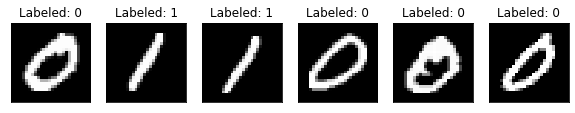

In [3]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [4]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

# idx = np.append(idx, 
#                 np.where(X_test.targets == 2)[0][:n_samples]
#                )
# idx = np.append(idx, 
#                 np.where(X_test.targets == 3)[0][:n_samples]
#                )

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]



test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [5]:
def exctract_single_qubit_measurment(dict_of_counts, qubit_range):
#     print(dict_of_counts)
#     print(len(list(dict_of_counts.keys())[0]))
    num_qubits = len(list(dict_of_counts.keys())[0])
    result = np.zeros(len(qubit_range))
    result = np.zeros(num_qubits)
#     print(result)
    for el in dict_of_counts:
        for i in range(num_qubits):
#             print("i", i)
#             print("el[i]", el[i])
            if i in qubit_range and el[i] == '1':
                result[i] += dict_of_counts[el]
#     print(result)
#     print(result[qubit_range])
    return result[qubit_range]

In [6]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
#         print("states: ", states)
#         print("probabilities: ", probabilities)
        
        new_probabilities = exctract_single_qubit_measurment(result, list(range(self.n_qubits)))/self.shots
#         print("new_probabilities: ", new_probabilities)
#         new_expectation = np.sum(states * new_probabilities)
#         print("old expectation", np.array([expectation]))
        return new_probabilities
#         return np.array([expectation])

In [7]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(2, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.42


┌───┐ ░ ┌───────────┐ ░ ┌─┐   
     q_0: |0>┤ H ├─░─┤ Ry(theta) ├─░─┤M├───
             ├───┤ ░ ├───────────┤ ░ └╥┘┌─┐
     q_1: |0>┤ H ├─░─┤ Ry(theta) ├─░──╫─┤M├
             └───┘ ░ └───────────┘ ░  ║ └╥┘
measure_0: 0 ═════════════════════════╩══╬═
                                         ║ 
measure_1: 0 ════════════════════════════╩═

In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
#         print("FORWARD BEGIN")
#         print("input: ", input)
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
#         print("expectation_z: ", expectation_z)
        result = torch.tensor([expectation_z])
#         print("result", result)
        ctx.save_for_backward(input, result)
#         print("FORWARD END")
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
#         print("BACKWARD BEGIN")
#         print("Grad_output: ", grad_output)
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
#         print("input_list: ", input.tolist())
        
        input_list = np.array(input.tolist())
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = expectation_right - expectation_left
            gradients.append(gradient)
#         print("HALO")
        
        gradients = np.array([gradients]).T

#         print("gradients: ", gradients)
#         print("BACKWARD END")
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(2, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(6400, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 6400)
        x = F.relu(self.fc1(x))
#         print(x.size())
        x = self.fc2(x)
#         print("x before hybrid layer", x)
#         print(x.size())
        x = self.hybrid(x)
#         print("x after hybrid layer", x)
#         x = F.relu(self.fc3(x.float()))
#         print("return: ", torch.cat((x, 1 - x), -1))
        x = self.fc3(x.float())
#         print(torch.cat((x, 1 - x), -1))
#         return torch.cat((x, 1 - x), -1)
#         print("softmax: ", F.softmax(x))
#         print("argmax: ", torch.argmax(x))
        return F.softmax(x)
#         return torch.argmax(x)
#         

In [10]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(target)
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training [5%]	Loss: 0.6486
Training [10%]	Loss: 0.5892
Training [15%]	Loss: 0.5568
Training [20%]	Loss: 0.5287
Training [25%]	Loss: 0.5059
Training [30%]	Loss: 0.4825
Training [35%]	Loss: 0.4669
Training [40%]	Loss: 0.4465
Training [45%]	Loss: 0.4454
Training [50%]	Loss: 0.4343
Training [55%]	Loss: 0.4143
Training [60%]	Loss: 0.4104
Training [65%]	Loss: 0.4013
Training [70%]	Loss: 0.4084
Training [75%]	Loss: 0.4488
Training [80%]	Loss: 0.3774
Training [85%]	Loss: 0.3739
Training [90%]	Loss: 0.3857
Training [95%]	Loss: 0.3692
Training [100%]	Loss: 0.4065


Text(0, 0.5, 'Neg Log Likelihood Loss')

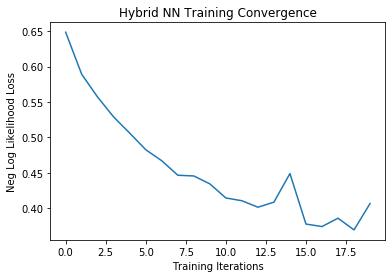

In [11]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [12]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Performance on test data:
	Loss: 0.3915
	Accuracy: 100.0%


c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


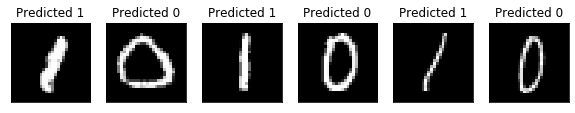

In [13]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

In [13]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.13.0',
 'qiskit-aer': '0.5.0',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.6.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.18.0'}